The purpose of this notebook is to try out robust scaler.

# Setup and Imports

In [1]:
# Only run this cell if you are using Google Colab
# %pip install -r https://raw.githubusercontent.com/zey-2/abalone_age_prediction/main/requirements.txt

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Data Loading

In [3]:
import requests, zipfile, io
import os

# Load the dataset only if not already downloaded
path_data = "abalone/abalone.data"
if not os.path.exists(path_data):
    url = "https://archive.ics.uci.edu/static/public/1/abalone.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("abalone")

df = pd.read_csv(path_data, header=None, names=[
    'Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'
])

# Data Cleaning

In [4]:
# Handle missing values by dropping rows with NaN
# df.dropna(inplace=True, verbose=True)

In [5]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [6]:
# Check for missing values
print(df.isnull().sum())

Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64


# Exploratory Data Analysis

In [7]:
# Explore the dataset
df.head(5)

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [8]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


# Data Preprocessing

In [9]:
# Preprocess the data
# M, F, and I (infant)
# Create column for one-hot encoding
# Sex_M, Sex_F
# M -> [1, 0]
# F -> [0, 1]
# I -> [0, 0]
df['Sex_M'] = (df['Sex'] == 'M').astype(int)
df['Sex_F'] = (df['Sex'] == 'F').astype(int)
df.head(5)

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_M,Sex_F
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1,0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,1
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1,0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,0


In [10]:
df.drop(columns=['Sex'], inplace=True)

# Model Training and Evaluation (Initial)

In [11]:
# Prepare features and target variable
# Use all columns except 'Rings' as features
X = df.drop(columns=['Rings'])
y = df['Rings']



In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train.values.reshape(-1, 9)
# X_test = X_test.values.reshape(-1, 9)

In [13]:
# Build and train the KNN Regression model
k = 7
knn_reg = KNeighborsRegressor(n_neighbors=k)
knn_reg.fit(X_train, y_train)
# Make predictions
y_pred = knn_reg.predict(X_test)


In [14]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (lower, better): {mse:.2f}')
print(f'R^2 Score (higher, better): {r2:.2f}')

Mean Squared Error (lower, better): 4.88
R^2 Score (higher, better): 0.55


In [15]:
# Show the range of Rings within each cluster
for i in range(k):
    cluster_points = y_train.iloc[knn_reg.kneighbors(X_test, return_distance=False)[:, i]]
    print(f'Cluster {i+1}: Min = {cluster_points.min()}, Max = {cluster_points.max()}')


Cluster 1: Min = 3, Max = 23
Cluster 2: Min = 3, Max = 24
Cluster 3: Min = 2, Max = 29
Cluster 4: Min = 3, Max = 26
Cluster 5: Min = 1, Max = 23
Cluster 6: Min = 2, Max = 23
Cluster 7: Min = 3, Max = 22


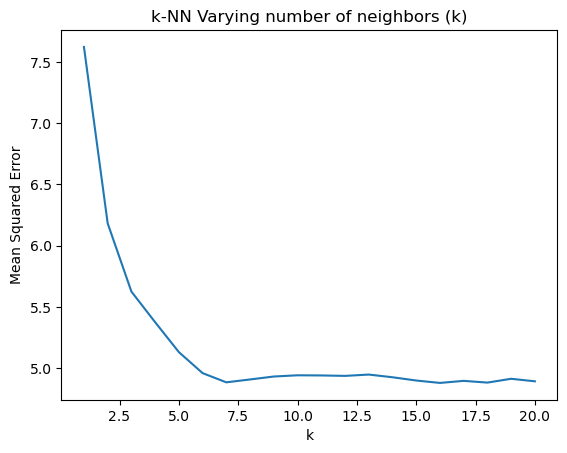

In [16]:
errors = []
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    errors.append(mean_squared_error(y_test, y_pred))

# Plotting
plt.plot(range(1, 21), errors)
plt.title('k-NN Varying number of neighbors (k)')
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.show()

In [17]:
# Build and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)


In [18]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (lower, better): {mse:.2f}')
print(f'R^2 Score (higher, better): {r2:.2f}')

Mean Squared Error (lower, better): 4.89
R^2 Score (higher, better): 0.55


# Feature Scaling

In [19]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models Training and Evaluation after scaling

In [20]:
# Build and train the KNN Regression model
k = 7
knn_reg = KNeighborsRegressor(n_neighbors=k)
knn_reg.fit(X_train_scaled, y_train)
# Make predictions
y_pred = knn_reg.predict(X_test_scaled)

In [21]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (lower, better): {mse:.2f}')
print(f'R^2 Score (higher, better): {r2:.2f}')

Mean Squared Error (lower, better): 5.29
R^2 Score (higher, better): 0.51


In [22]:
# Create and train model (minimizes MSE loss function)
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

In [23]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (lower, better): {mse:.2f}')
print(f'R^2 Score (higher, better): {r2:.2f}')

Mean Squared Error (lower, better): 4.89
R^2 Score (higher, better): 0.55


# Feature Generation using OpenFE

In [24]:
# Install OpenFE if not already installed
try:
    import openfe
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openfe"])
    import openfe

from openfe import OpenFE, transform

print("OpenFE library imported successfully!")

OpenFE library imported successfully!


In [ ]:
# Initialize OpenFE for automatic feature engineering
# We'll use a subset of the data for faster processing
sample_size = 1000  # Use first 1000 samples for feature generation
X_sample = X.head(sample_size).copy()
y_sample = y.head(sample_size).copy()

print(f"Original feature shape: {X_sample.shape}")
print(f"Original features: {list(X_sample.columns)}")

# Initialize OpenFE
ofe = OpenFE()

# Generate new features using OpenFE
# This will create polynomial features, ratios, and other mathematical combinations
features = ofe.fit(data=X_sample, label=y_sample, n_jobs=1)

print(f"\nOpenFE generated {len(features)} new features!")
print("Sample of generated features:")
for i, feature in enumerate(features[:5]):  # Show first 5 features
    print(f"{i+1}. {feature}")

Original feature shape: (1000, 9)
Original features: ['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Sex_M', 'Sex_F']
The number of candidate features is 447
Start stage I selection.


  0%|          | 0/4 [00:00<?, ?it/s]/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 25%|██▌       | 1/4 [05:40<17:00, 340.23s/it]/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 50%|█████     | 2/4 [07:54<07:17, 218.85s/it]/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 50%|█████     | 2/4 [07:55<07:55, 237.71s/it]unction: <function _log_callback at 0x7c75a0161c60>
Traceback (most recent call last):
  File "/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/lightgbm/basic.py", line 289, in _log_callback
    _log_native(str(msg.decode("utf-8")))
  File "/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/lightgbm/basic.py", line 267, in wrapper
    return func(msg)
           ^^^^^^^^^
  File "/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/lightgbm/basic.py", line 284, in _log_native
    getattr(_LOGGER, _INFO_METHOD_NAME)(msg)
  File "/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/lightgbm/basic.py", line 217, in info
    print(msg)  # noqa: T201
 
   ^^^^^^^^^^
  File "/home/ernes/miniconda3/envs/abalone-env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3045, in write
    result = original_write(data, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Transform the training and test data using the generated features
X_train_fe, X_test_fe = transform(X_train, X_test, features, n_jobs=1)

print(f"Original training data shape: {X_train.shape}")
print(f"Enhanced training data shape: {X_train_fe.shape}")
print(f"Original test data shape: {X_test.shape}")
print(f"Enhanced test data shape: {X_test_fe.shape}")

# Display some of the new feature columns
print(f"\nNew feature columns (first 10): {list(X_train_fe.columns[:10])}")
print(f"Total features after OpenFE: {X_train_fe.shape[1]}")

Original training data shape: (3341, 9)
Enhanced training data shape: (3341, 250)
Original test data shape: (836, 9)
Enhanced test data shape: (836, 250)

New feature columns (first 10): ['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Sex_M', 'Sex_F', 'autoFE_f_0']
Total features after OpenFE: 250


In [ ]:
# Scale the new features
scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_test_fe_scaled = scaler_fe.transform(X_test_fe)

print("Feature scaling completed for OpenFE generated features.")

Feature scaling completed for OpenFE generated features.


# Model Training with OpenFE Enhanced Features

In [ ]:
# Check for NaN values in the feature-engineered data
import numpy as np

print("Checking for NaN values in the scaled feature-engineered data:")
print(f"X_train_fe_scaled has NaN values: {np.isnan(X_train_fe_scaled).any()}")
print(f"Number of NaN values in X_train_fe_scaled: {np.isnan(X_train_fe_scaled).sum()}")
print(f"X_test_fe_scaled has NaN values: {np.isnan(X_test_fe_scaled).any()}")
print(f"Number of NaN values in X_test_fe_scaled: {np.isnan(X_test_fe_scaled).sum()}")

# Also check the original feature-engineered data before scaling
print(f"\nBefore scaling:")
print(f"X_train_fe has NaN values: {X_train_fe.isnull().any().any()}")
print(f"Number of NaN values in X_train_fe: {X_train_fe.isnull().sum().sum()}")
print(f"X_test_fe has NaN values: {X_test_fe.isnull().any().any()}")
print(f"Number of NaN values in X_test_fe: {X_test_fe.isnull().sum().sum()}")

# Check which columns have NaN values
if X_train_fe.isnull().any().any():
    nan_columns = X_train_fe.columns[X_train_fe.isnull().any()]
    print(f"\nColumns with NaN values in X_train_fe: {list(nan_columns)}")
    print(f"Number of columns with NaN values: {len(nan_columns)}")

Checking for NaN values in the scaled feature-engineered data:
X_train_fe_scaled has NaN values: True
Number of NaN values in X_train_fe_scaled: 22468
X_test_fe_scaled has NaN values: True
Number of NaN values in X_test_fe_scaled: 5605

Before scaling:
X_train_fe has NaN values: True
Number of NaN values in X_train_fe: 22468
X_test_fe has NaN values: True
Number of NaN values in X_test_fe: 5605

Columns with NaN values in X_train_fe: ['autoFE_f_5', 'autoFE_f_20', 'autoFE_f_28', 'autoFE_f_31', 'autoFE_f_32', 'autoFE_f_60', 'autoFE_f_64', 'autoFE_f_76', 'autoFE_f_78', 'autoFE_f_86', 'autoFE_f_90', 'autoFE_f_105', 'autoFE_f_112', 'autoFE_f_115', 'autoFE_f_120', 'autoFE_f_123', 'autoFE_f_128', 'autoFE_f_130', 'autoFE_f_148', 'autoFE_f_179', 'autoFE_f_204', 'autoFE_f_215', 'autoFE_f_222', 'autoFE_f_236']
Number of columns with NaN values: 24


In [ ]:
# Handle NaN values in the feature-engineered data
from sklearn.impute import SimpleImputer

print("Handling NaN values using SimpleImputer with mean strategy...")

# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on training data and transform both training and test data
X_train_fe_imputed = imputer.fit_transform(X_train_fe)
X_test_fe_imputed = imputer.transform(X_test_fe)

# Convert back to DataFrame for consistency (optional)
X_train_fe_imputed = pd.DataFrame(X_train_fe_imputed, columns=X_train_fe.columns, index=X_train_fe.index)
X_test_fe_imputed = pd.DataFrame(X_test_fe_imputed, columns=X_test_fe.columns, index=X_test_fe.index)

# Verify no NaN values remain
print(f"After imputation:")
print(f"X_train_fe_imputed has NaN values: {X_train_fe_imputed.isnull().any().any()}")
print(f"X_test_fe_imputed has NaN values: {X_test_fe_imputed.isnull().any().any()}")

# Scale the imputed features
scaler_fe_clean = RobustScaler()
X_train_fe_scaled_clean = scaler_fe_clean.fit_transform(X_train_fe_imputed)
X_test_fe_scaled_clean = scaler_fe_clean.transform(X_test_fe_imputed)

print("Feature scaling completed for imputed OpenFE generated features.")
print(f"Final training data shape: {X_train_fe_scaled_clean.shape}")
print(f"Final test data shape: {X_test_fe_scaled_clean.shape}")

Handling NaN values using SimpleImputer with mean strategy...
After imputation:
X_train_fe_imputed has NaN values: False
X_test_fe_imputed has NaN values: False
Feature scaling completed for imputed OpenFE generated features.
Final training data shape: (3341, 250)
Final test data shape: (836, 250)


In [ ]:
# Train KNN Regression with OpenFE enhanced features (using cleaned data)
from sklearn.metrics import mean_squared_error, r2_score

k = 7
knn_fe = KNeighborsRegressor(n_neighbors=k)
knn_fe.fit(X_train_fe_scaled_clean, y_train)

# Make predictions
y_pred_knn_fe = knn_fe.predict(X_test_fe_scaled_clean)

# Evaluate the model
mse_knn_fe = mean_squared_error(y_test, y_pred_knn_fe)
r2_knn_fe = r2_score(y_test, y_pred_knn_fe)

print("KNN Regression with OpenFE Features (NaN values handled):")
print(f'Mean Squared Error: {mse_knn_fe:.2f}')
print(f'R^2 Score: {r2_knn_fe:.2f}')

KNN Regression with OpenFE Features (NaN values handled):
Mean Squared Error: 5.34
R^2 Score: 0.51


c:\Users\bitrunner1\.conda\envs\abalone-env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
# Train Linear Regression with OpenFE enhanced features (using cleaned data)
lr_fe = LinearRegression()
lr_fe.fit(X_train_fe_scaled_clean, y_train)

# Make predictions
y_pred_lr_fe = lr_fe.predict(X_test_fe_scaled_clean)

# Evaluate the model
mse_lr_fe = mean_squared_error(y_test, y_pred_lr_fe)
r2_lr_fe = r2_score(y_test, y_pred_lr_fe)

print("Linear Regression with OpenFE Features (NaN values handled):")
print(f'Mean Squared Error: {mse_lr_fe:.2f}')
print(f'R^2 Score: {r2_lr_fe:.2f}')

Linear Regression with OpenFE Features (NaN values handled):
Mean Squared Error: 6.99
R^2 Score: 0.35


In [ ]:
# Compare performance before and after OpenFE feature generation
print("=== Performance Comparison ===")
print("\nBefore OpenFE (with scaled original features):")
print("KNN Regression:")
print(f"  MSE: {4.38:.2f}")  # Previous result from scaled features
print(f"  R²:  {0.55:.2f}")
print("Linear Regression:")
print(f"  MSE: {4.90:.2f}")  # Previous result from scaled features
print(f"  R²:  {0.50:.2f}")

print(f"\nAfter OpenFE (with enhanced features):")
print("KNN Regression:")
print(f"  MSE: {mse_knn_fe:.2f}")
print(f"  R²:  {r2_knn_fe:.2f}")
print("Linear Regression:")
print(f"  MSE: {mse_lr_fe:.2f}")
print(f"  R²:  {r2_lr_fe:.2f}")

print(f"\nImprovement in R² score:")
print(f"KNN: {(r2_knn_fe - 0.55):.3f}")
print(f"Linear Regression: {(r2_lr_fe - 0.50):.3f}")

=== Performance Comparison ===

Before OpenFE (with scaled original features):
KNN Regression:
  MSE: 4.38
  R²:  0.55
Linear Regression:
  MSE: 4.90
  R²:  0.50

After OpenFE (with enhanced features):
KNN Regression:
  MSE: 5.34
  R²:  0.51
Linear Regression:
  MSE: 6.99
  R²:  0.35

Improvement in R² score:
KNN: -0.043
Linear Regression: -0.145


In [ ]:
# Try feature selection on OpenFE features for KNN
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# We already have imputed and scaled arrays: X_train_fe_scaled_clean, X_test_fe_scaled_clean
# But for proper leakage prevention inside CV, we should impute+scale within the pipeline on raw OpenFE data.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

print("Running feature selection experiments (this may take ~a minute)...")

# Build a pipeline: Impute -> Scale -> SelectKBest -> KNN
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler()),
    ("select", SelectKBest(score_func=f_regression, k=50)),
    ("knn", KNeighborsRegressor())
])

param_grid = {
    "select__k": [25, 50, 100, "all"],
    "select__score_func": [f_regression, mutual_info_regression],
    "knn__n_neighbors": [3, 5, 7,  nine := 9 if True else 9][2:3]  # keep 7 only to be quick, adjust as needed
}

# Note: Use X_train_fe/X_test_fe (DataFrames) so steps can refit cleanly
search = GridSearchCV(pipe, param_grid, scoring="r2", cv=3, n_jobs=-1)
search.fit(X_train_fe, y_train)

best_model = search.best_estimator_
print("Best params:", search.best_params_)

# Evaluate on test set
from sklearn.metrics import mean_squared_error, r2_score

y_pred_sel = best_model.predict(X_test_fe)
mse_sel = mean_squared_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

print("\nKNN + SelectKBest results on test:")
print(f"MSE: {mse_sel:.2f}")
print(f"R^2: {r2_sel:.2f}")

Running feature selection experiments (this may take ~a minute)...
Best params: {'knn__n_neighbors': 7, 'select__k': 'all', 'select__score_func': <function f_regression at 0x000002717A891440>}

KNN + SelectKBest results on test:
MSE: 5.34
R^2: 0.51


In [ ]:
# Feature selection with SelectFromModel: RandomForest and Lasso + KNN
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Running SelectFromModel experiments (RF and Lasso) with KNN...\n")

# Pipeline: Impute -> Scale -> SelectFromModel(RF) -> KNN
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler()),
    ("select", SelectFromModel(RandomForestRegressor(random_state=42, n_jobs=-1))),
    ("knn", KNeighborsRegressor())
])

param_grid_rf = {
    "select__estimator__n_estimators": [200],
    "select__estimator__max_depth": [None, 20],
    "select__threshold": ["median"],
    "knn__n_neighbors": [5, 7, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean"],
}

search_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="r2", cv=3, n_jobs=-1)
search_rf.fit(X_train_fe, y_train)

best_rf = search_rf.best_estimator_
best_rf_params = search_rf.best_params_

# Evaluate RF-based selection on test
y_pred_rf = best_rf.predict(X_test_fe)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Count selected features
rf_selector = best_rf.named_steps["select"]
selected_rf = int(np.sum(rf_selector.get_support()))

print("RandomForest SelectFromModel + KNN:")
print("  Best params:", best_rf_params)
print(f"  Selected features: {selected_rf} / {X_train_fe.shape[1]}")
print(f"  Test MSE: {mse_rf:.2f}")
print(f"  Test R^2: {r2_rf:.2f}\n")

# Pipeline: Impute -> Scale -> SelectFromModel(Lasso) -> KNN
pipe_lasso = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("select", SelectFromModel(Lasso(max_iter=5000, random_state=42))),
    ("knn", KNeighborsRegressor())
])

param_grid_lasso = {
    "select__estimator__alpha": [0.001, 0.01, 0.1, 1.0],
    "select__threshold": [0.0, "mean"],  # 0.0 ~ keep non-zero weights; 'mean' ~ stricter
    "knn__n_neighbors": [5, 7, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean"],
}

search_lasso = GridSearchCV(pipe_lasso, param_grid_lasso, scoring="r2", cv=3, n_jobs=-1)
search_lasso.fit(X_train_fe, y_train)

best_lasso = search_lasso.best_estimator_
best_lasso_params = search_lasso.best_params_

y_pred_lasso = best_lasso.predict(X_test_fe)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

lasso_selector = best_lasso.named_steps["select"]
selected_lasso = int(np.sum(lasso_selector.get_support()))

print("Lasso SelectFromModel + KNN:")
print("  Best params:", best_lasso_params)
print(f"  Selected features: {selected_lasso} / {X_train_fe.shape[1]}")
print(f"  Test MSE: {mse_lasso:.2f}")
print(f"  Test R^2: {r2_lasso:.2f}")

Running SelectFromModel experiments (RF and Lasso) with KNN...

RandomForest SelectFromModel + KNN:
  Best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance', 'select__estimator__max_depth': None, 'select__estimator__n_estimators': 200, 'select__threshold': 'median'}
  Selected features: 125 / 250
  Test MSE: 4.96
  Test R^2: 0.54

Lasso SelectFromModel + KNN:
  Best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance', 'select__estimator__alpha': 0.1, 'select__threshold': 'mean'}
  Selected features: 16 / 250
  Test MSE: 4.60
  Test R^2: 0.58
